# Entrenamiento Vit

2025-08-22 14:41:58.913157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-22 14:41:59.643881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-08-22 14:43:01.166752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-22 14:43:01.190592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Epoch 1/300


2025-08-22 14:43:13.881877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-22 14:43:14.013555: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x710fa04e4f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-22 14:43:14.013575: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-22 14:43:14.055307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-22 14:43:14.138914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-08-22 14:43:14.402221: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

145/145 [==============================] - 47s 229ms/step - loss: 0.7384 - accuracy: 0.5467 - val_loss: 0.6034 - val_accuracy: 0.6991
Epoch 2/300
145/145 [==============================] - 30s 208ms/step - loss: 0.5238 - accuracy: 0.7402 - val_loss: 0.4578 - val_accuracy: 0.7884
Epoch 3/300
145/145 [==============================] - 30s 207ms/step - loss: 0.4497 - accuracy: 0.7837 - val_loss: 0.4170 - val_accuracy: 0.8047
Epoch 4/300
145/145 [==============================] - 30s 208ms/step - loss: 0.4015 - accuracy: 0.8211 - val_loss: 0.3399 - val_accuracy: 0.8573
Epoch 5/300
145/145 [==============================] - 30s 204ms/step - loss: 0.3772 - accuracy: 0.8283 - val_loss: 0.3503 - val_accuracy: 0.8526
Epoch 6/300
145/145 [==============================] - 30s 207ms/step - loss: 0.3453 - accuracy: 0.8468 - val_loss: 0.3263 - val_accuracy: 0.8522
Epoch 7/300
145/145 [==============================] - 30s 205ms/step - loss: 0.3907 - accuracy: 0.8244 - val_loss: 0.3411 - val_accurac

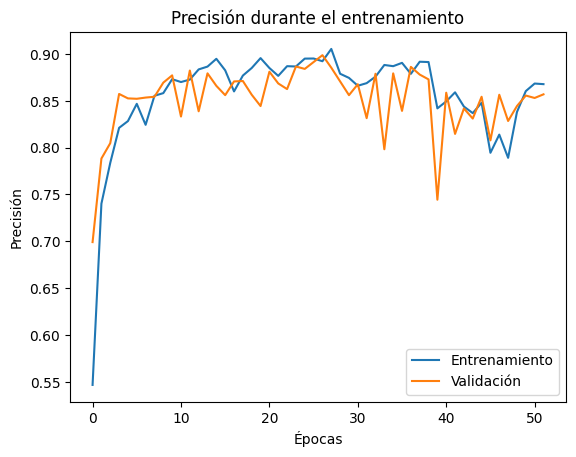

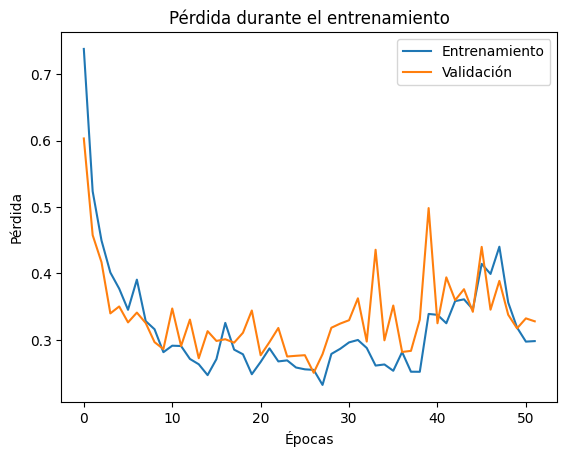

73/73 [==============================] - 3s 39ms/step


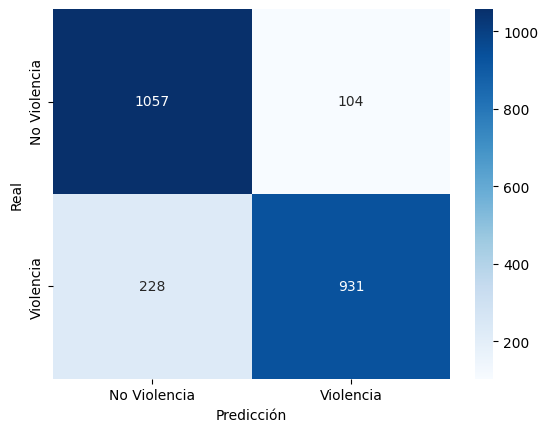

Modelo guardado como 'vit.h5' (ahora es un ViT)


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense  # dejamos Dense; ya no usamos GAP2D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import DenseNet121  # <- YA NO SE USA
from tensorflow.keras import layers

# ------------------ CAPAS AUXILIARES PARA VISION TRANSFORMER ------------------

class PatchExtract(layers.Layer):
    """Extrae patches no superpuestos de tamaño patch_size x patch_size."""
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size  # 3 * P * P
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches  # (B, num_patches, patch_dim)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    """Proyección lineal a d_model, añade [CLS] y embedding posicional aprendible."""
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight(
            "cls", shape=(1, 1, d_model), initializer="zeros", trainable=True
        )
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )

    def call(self, patches):
        x = self.proj(patches)                      # (B, N, d_model)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)         # (B, N+1, d_model)
        return x + self.pos_emb                     # agrega posiciones

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ------------------ TUS RUTAS ------------------

# Directorios de las imágenes
ruta_violentas = "../dataset/violencia"
ruta_no_violentas = "../dataset/no_violencia"

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    # Convertir las listas a arrays de numpy
    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes (0 a 1)
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# ------------------ AQUI CAMBIAMOS A TRANSFORMER (ViT "tiny") ------------------

def create_model():
    # Hiperparámetros ViT
    image_size = 224
    patch_size = 16
    num_patches = (image_size // patch_size) ** 2  # 14*14=196
    d_model = 256
    num_heads = 8
    mlp_dim = 512
    num_layers = 6
    dropout = 0.1

    inputs = layers.Input(shape=(image_size, image_size, 3))

    # 1) Patch embedding + [CLS] + posiciones
    x = PatchExtract(patch_size, name="patch_extract")(inputs)      # (B, N, 3*P*P)
    x = PatchEncoder(num_patches, d_model, name="patch_encoder")(x) # (B, N+1, d_model)

    # 2) Bloques Transformer (PreNorm)
    for i in range(num_layers):
        # Atención multi-cabeza
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout, name=f"mha_{i}"
        )(x1, x1)
        x = layers.Add(name=f"skip_attn_{i}")([x, attn])

        # MLP
        x2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation=tf.keras.activations.gelu, name=f"mlp_fc1_{i}")(x2)
        mlp = layers.Dropout(dropout, name=f"mlp_do1_{i}")(mlp)
        mlp = layers.Dense(d_model, name=f"mlp_fc2_{i}")(mlp)
        mlp = layers.Dropout(dropout, name=f"mlp_do2_{i}")(mlp)
        x = layers.Add(name=f"skip_mlp_{i}")([x, mlp])

    # 3) Tomar el token [CLS] y clasificar (dos clases con softmax para tus one-hot)
    x = layers.LayerNormalization(epsilon=1e-6, name="ln_head")(x)
    cls_token = layers.Lambda(lambda t: t[:, 0], name="take_cls")(x)
    x = layers.Dense(1024, activation='relu', name="head_dense")(cls_token)
    predictions = layers.Dense(2, activation='softmax', name="pred")(x)

    model = Model(inputs=inputs, outputs=predictions, name="ViT_tiny_binary")

    # Compilar (mantenemos tu configuración de pérdida y métrica)
    model.compile(optimizer=Adam(lr=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ------------------ ENTRENAMIENTO (SIN CAMBIOS EN TU FLUJO) ------------------

def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=64):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[ 
            tf.keras.callbacks.EarlyStopping(patience=25),
            tf.keras.callbacks.ModelCheckpoint('modelo_mejorado_vit.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )
    return model_history

def plot_training_history(model_history):
    # Precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Violencia', 'Violencia'],
                yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# ------------------ EJECUCIÓN (SIN CAMBIOS) ------------------

# Cargar las imágenes y etiquetas
imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)

# Dividir en conjunto de entrenamiento y validación (80% - 20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)

# Crear el modelo (ahora ViT)
model = create_model()

# Entrenar el modelo
model_history = train_model(model, X_train, y_train, X_val, y_val)

# Graficar resultados
plot_training_history(model_history)

# Matriz de confusión
plot_confusion_matrix(model, X_val, y_val)

# Guardar el modelo entrenado
model.save('vit.h5')  # puedes renombrar si quieres: 'Modelo_ViT.h5'
print("Modelo guardado como 'vit.h5' (ahora es un ViT)")


# MC Confusion

2025-08-22 15:14:43.886614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-22 15:14:44.883540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-08-22 15:15:10.918249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-22 15:15:11.101331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Modelo cargado: modelo_mejorado_vit.h5


2025-08-22 15:15:15.727848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Matriz de Confusión (filas = Real, columnas = Predicho):
[[1986  214]
 [ 291 1909]]


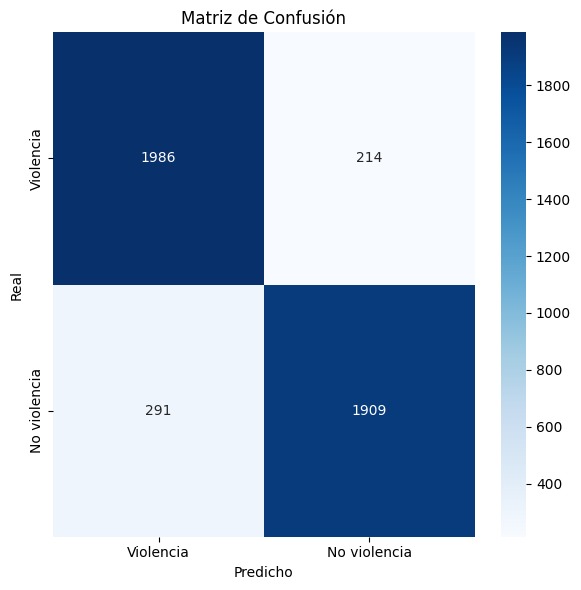


Métricas por clase:
- Violencia: precision=0.872, recall=0.903, f1=0.887
- No violencia: precision=0.899, recall=0.868, f1=0.883

Macro-average: precision=0.886, recall=0.885, f1=0.885

Classification report:

              precision    recall  f1-score   support

   Violencia       0.87      0.90      0.89      2200
No violencia       0.90      0.87      0.88      2200

    accuracy                           0.89      4400
   macro avg       0.89      0.89      0.89      4400
weighted avg       0.89      0.89      0.89      4400



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf

# ================= Capas custom necesarias para cargar el ViT =================
class PatchExtract(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        bs = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dim = images.shape[-1] * self.patch_size * self.patch_size
        patches = tf.reshape(patches, [bs, -1, patch_dim])
        return patches
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj = layers.Dense(d_model)
        self.cls = self.add_weight("cls", shape=(1,1,d_model), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, num_patches + 1, d_model),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.06),
            trainable=True,
        )
    def call(self, patches):
        x = self.proj(patches)
        b = tf.shape(x)[0]
        cls_tok = tf.broadcast_to(self.cls, [b, 1, tf.shape(x)[-1]])
        x = tf.concat([cls_tok, x], axis=1)
        return x + self.pos_emb
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"num_patches": self.num_patches, "d_model": self.proj.units})
        return cfg

# ===================== Paths del test =====================
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# ===================== Carga de datos =====================
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes, etiquetas = [], []
    for filename in os.listdir(ruta_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([1, 0])  # [1,0] = Violencia -> clase 0
    for filename in os.listdir(ruta_no_violencia):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(ruta_no_violencia, filename)
            img = load_img(p, target_size=(224, 224))
            imagenes.append(img_to_array(img))
            etiquetas.append([0, 1])  # [0,1] = No violencia -> clase 1
    X = np.array(imagenes, dtype="float32") / 255.0
    y = np.array(etiquetas, dtype="int32")
    return X, y

X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)
if X_test.size == 0:
    raise RuntimeError("El set de test está vacío o las rutas no contienen imágenes válidas.")

# ===================== Cargar modelo ViT =====================
customs = {"PatchExtract": PatchExtract, "PatchEncoder": PatchEncoder}
candidatos = ["modelo_mejorado_vit.h5", "vit.h5"]  # ajusta si usas otro nombre
modelo = None
for path in candidatos:
    if os.path.exists(path):
        modelo = load_model(path, custom_objects=customs, compile=False)
        print(f"Modelo cargado: {path}")
        break
if modelo is None:
    raise FileNotFoundError("No se encontró ninguno de: " + ", ".join(candidatos))

# ===================== Predicciones =====================
pred = modelo.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Importante: fijamos el orden de clases para que heatmap y métricas coincidan
# clase 0 = Violencia, clase 1 = No violencia
labels = [0, 1]
class_names = ["Violencia", "No violencia"]

# ===================== Matriz de confusión =====================
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Matriz de Confusión (filas = Real, columnas = Predicho):")
print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicho")
plt.tight_layout()
plt.savefig("matriz_confusion.png", dpi=150)
plt.show()

# ===================== Métricas =====================
# Por clase (0=Violencia, 1=No violencia)
prec_por_clase = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
rec_por_clase  = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
f1_por_clase   = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

print("\nMétricas por clase:")
for i, name in enumerate(class_names):
    print(f"- {name}: precision={prec_por_clase[i]:.3f}, recall={rec_por_clase[i]:.3f}, f1={f1_por_clase[i]:.3f}")

# Macro (promedio simple) para vista global
print("\nMacro-average:",
      f"precision={precision_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"recall={recall_score(y_true, y_pred, average='macro', zero_division=0):.3f},",
      f"f1={f1_score(y_true, y_pred, average='macro', zero_division=0):.3f}")

# Reporte completo (útil si luego cambias a más clases)
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
